<a href="https://colab.research.google.com/github/josuesandoval-beep/Final-Project-Bank-Marketing/blob/main/Final_Project_Bank_Marketing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [76]:
!pip install ucimlrepo

In [77]:
#adding all the imports
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import CategoricalNB
from sklearn.preprocessing import StandardScaler,OrdinalEncoder,OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline,make_pipeline
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, roc_curve
from sklearn import metrics

from ucimlrepo import fetch_ucirepo

## Installling the UCI ML repository

set up instructions - https://github.com/uci-ml-repo/ucimlrepo

In [78]:
# fetch dataset
bank_marketing = fetch_ucirepo(id=222)

# data (as pandas dataframes)
X = bank_marketing.data.features
y = bank_marketing.data.targets

# variable information
print(bank_marketing.variables)


           name     role         type      demographic  \
0           age  Feature      Integer              Age   
1           job  Feature  Categorical       Occupation   
2       marital  Feature  Categorical   Marital Status   
3     education  Feature  Categorical  Education Level   
4       default  Feature       Binary             None   
5       balance  Feature      Integer             None   
6       housing  Feature       Binary             None   
7          loan  Feature       Binary             None   
8       contact  Feature  Categorical             None   
9   day_of_week  Feature         Date             None   
10        month  Feature         Date             None   
11     duration  Feature      Integer             None   
12     campaign  Feature      Integer             None   
13        pdays  Feature      Integer             None   
14     previous  Feature      Integer             None   
15     poutcome  Feature  Categorical             None   
16            

**Dataset Description**
Data source:

UCI Machine Learning Repository - https://archive.ics.uci.edu/dataset/222/bank+marketing

Number of Variables: 16 features

*   5 Categorical
*   6 Integer
*   3 Binary
*   2 Date

Size of Dataset: The dataset has a total of 45,211 entires.There are some misssing values for some features.

In [79]:
#get a summary of the features and target
print(X.info())
print(X.describe())
print(y.info())
print(y.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45211 entries, 0 to 45210
Data columns (total 16 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   age          45211 non-null  int64 
 1   job          44923 non-null  object
 2   marital      45211 non-null  object
 3   education    43354 non-null  object
 4   default      45211 non-null  object
 5   balance      45211 non-null  int64 
 6   housing      45211 non-null  object
 7   loan         45211 non-null  object
 8   contact      32191 non-null  object
 9   day_of_week  45211 non-null  int64 
 10  month        45211 non-null  object
 11  duration     45211 non-null  int64 
 12  campaign     45211 non-null  int64 
 13  pdays        45211 non-null  int64 
 14  previous     45211 non-null  int64 
 15  poutcome     8252 non-null   object
dtypes: int64(7), object(9)
memory usage: 5.5+ MB
None
                age        balance   day_of_week      duration      campaign  \
count  45211.00000

The catergory 'day_of_week' is given a five-number summary but since it's of type 'date' then the summary is irrelavent.

# EDA (Exploratory Data Analysis)

In [80]:
bankdata = pd.concat([X, y], axis=1)

num_cols = ['age', 'balance', 'day_of_week', 'duration', 'campaign', 'pdays', 'previous']
cat_cols = ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'poutcome','y']

bankdata.head()

,age,job,marital,education,default,balance,housing,loan,contact,day_of_week,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,NaN,5,may,261,1,-1,0,NaN,no
1,44,technician,single,secondary,no,29,yes,no,NaN,5,may,151,1,-1,0,NaN,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,NaN,5,may,76,1,-1,0,NaN,no
3,47,blue-collar,married,NaN,no,1506,yes,no,NaN,5,may,92,1,-1,0,NaN,no
4,33,NaN,single,NaN,no,1,no,no,NaN,5,may,198,1,-1,0,NaN,no


## Univariate Analysis

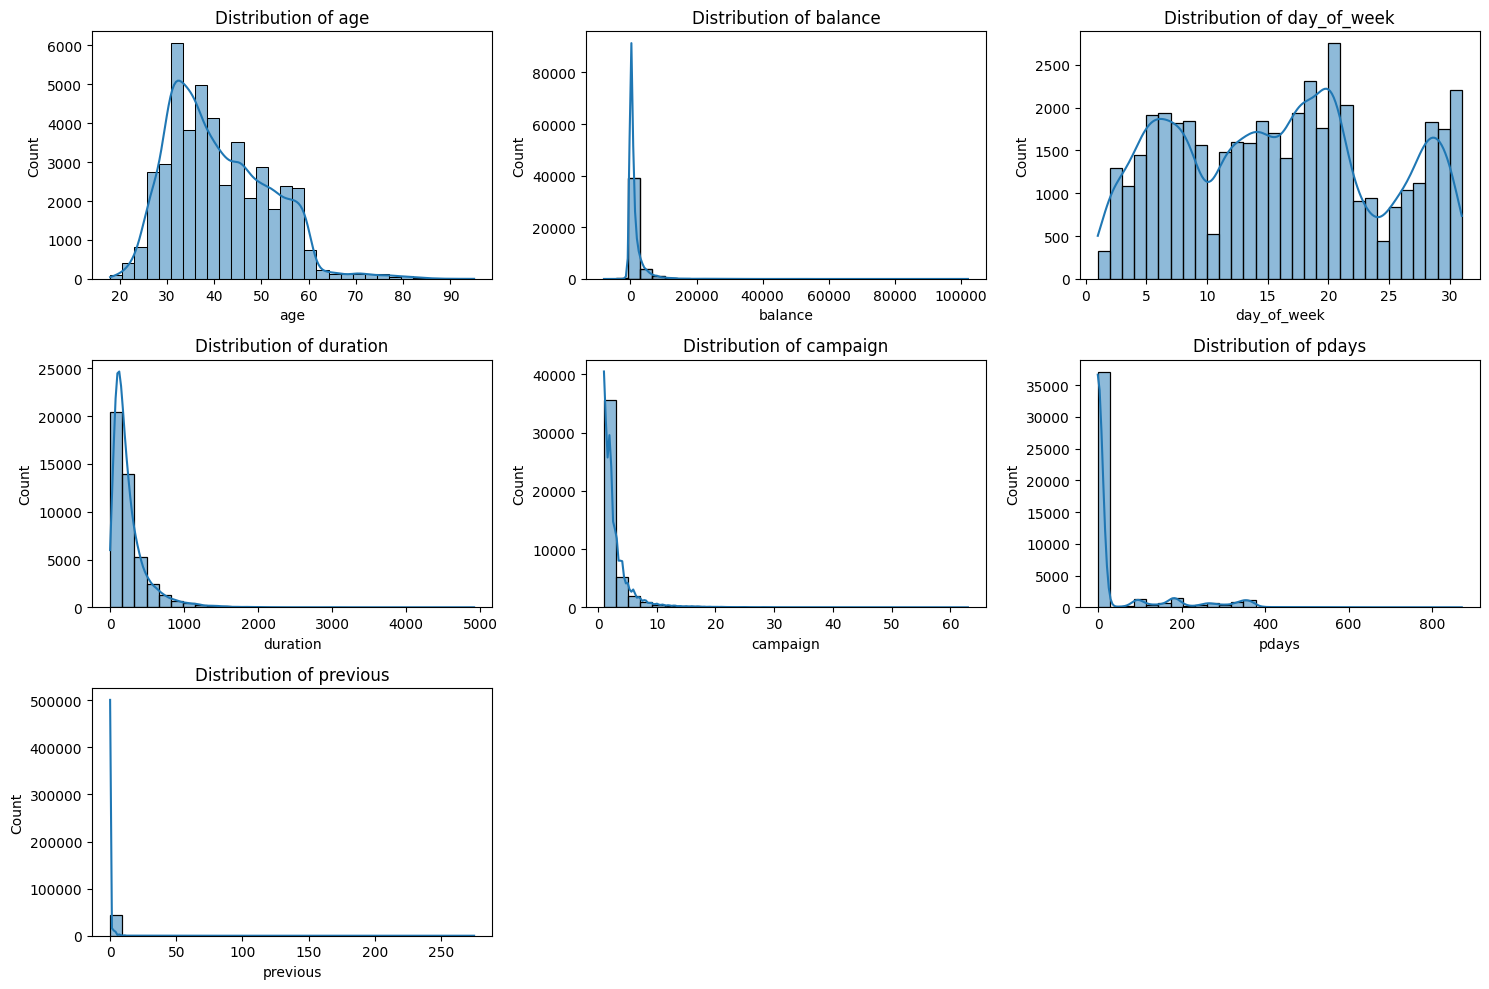

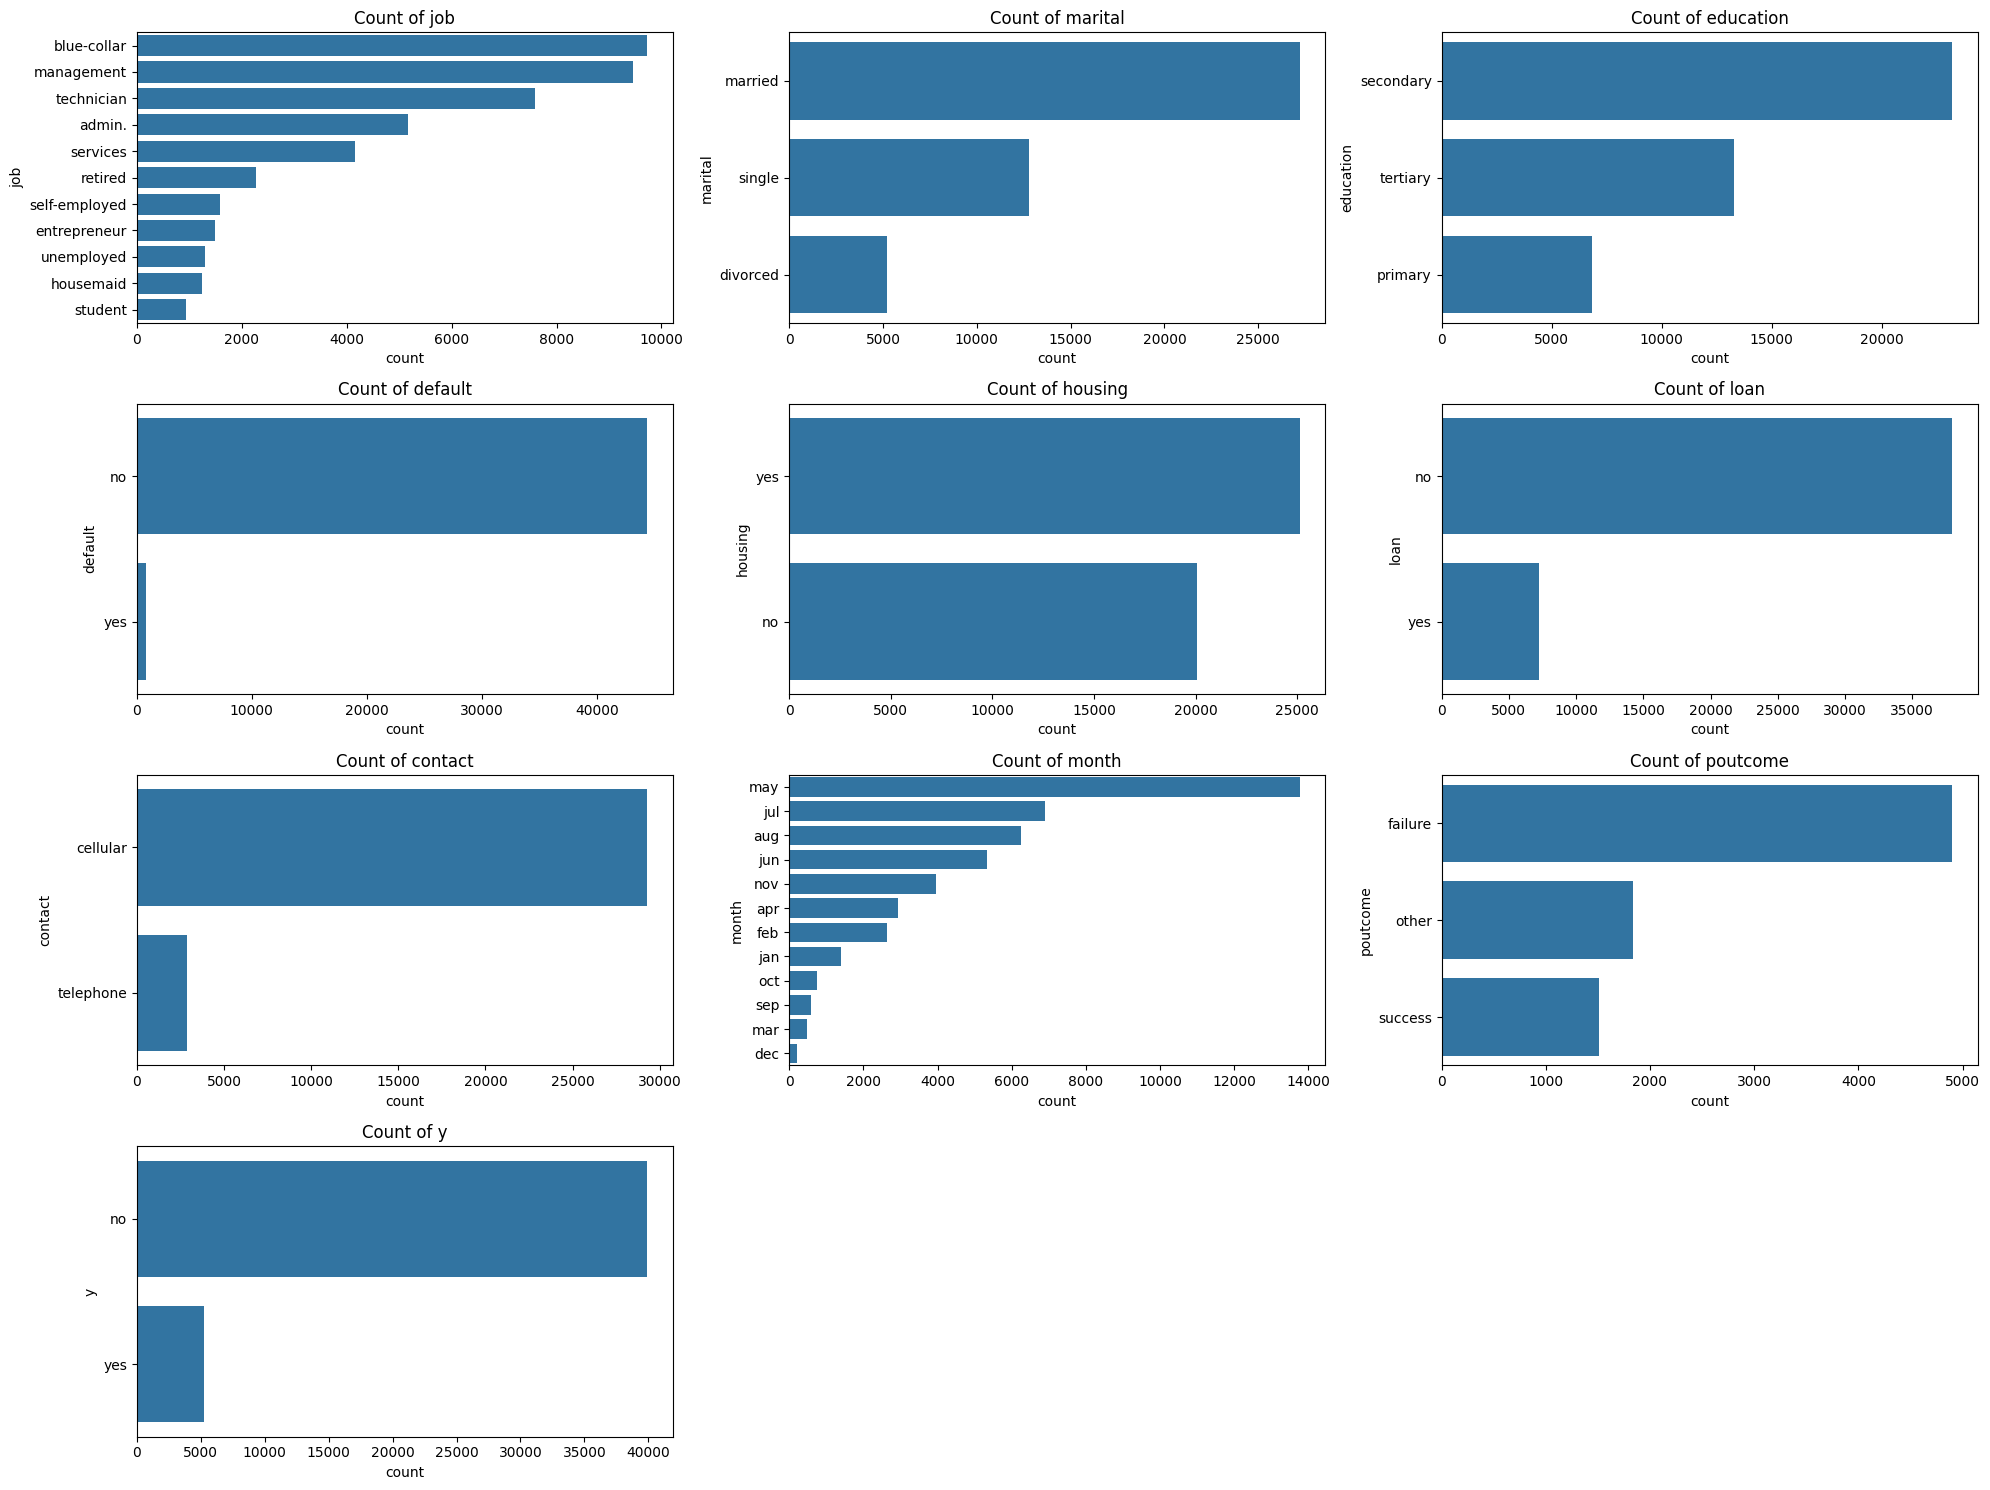

In [81]:
# --- Numerical Variables ---
plt.figure(figsize=(15, 10))
for i, col in enumerate(num_cols):
    plt.subplot(3, 3, i + 1)
    sns.histplot(bankdata[col], kde=True, bins=30)
    plt.title(f'Distribution of {col}')
    plt.tight_layout()
plt.show()

# --- Categorical Variables ---
plt.figure(figsize=(20, 15))
for i, col in enumerate(cat_cols):
    plt.subplot(4, 3, i + 1)
    # Order bars by count for better readability
    sns.countplot(y=bankdata[col], order=bankdata[col].value_counts().index)
    plt.title(f'Count of {col}')
    plt.tight_layout()
plt.show()

*   Age, Balance, Duration are right skewed
*   Job, indicates majority of the people are either in Management, blue-color.
*   The target variable most of them in the dataset are with value "no", indicating an imbalance target variable dataset


## BiVariate Analysis

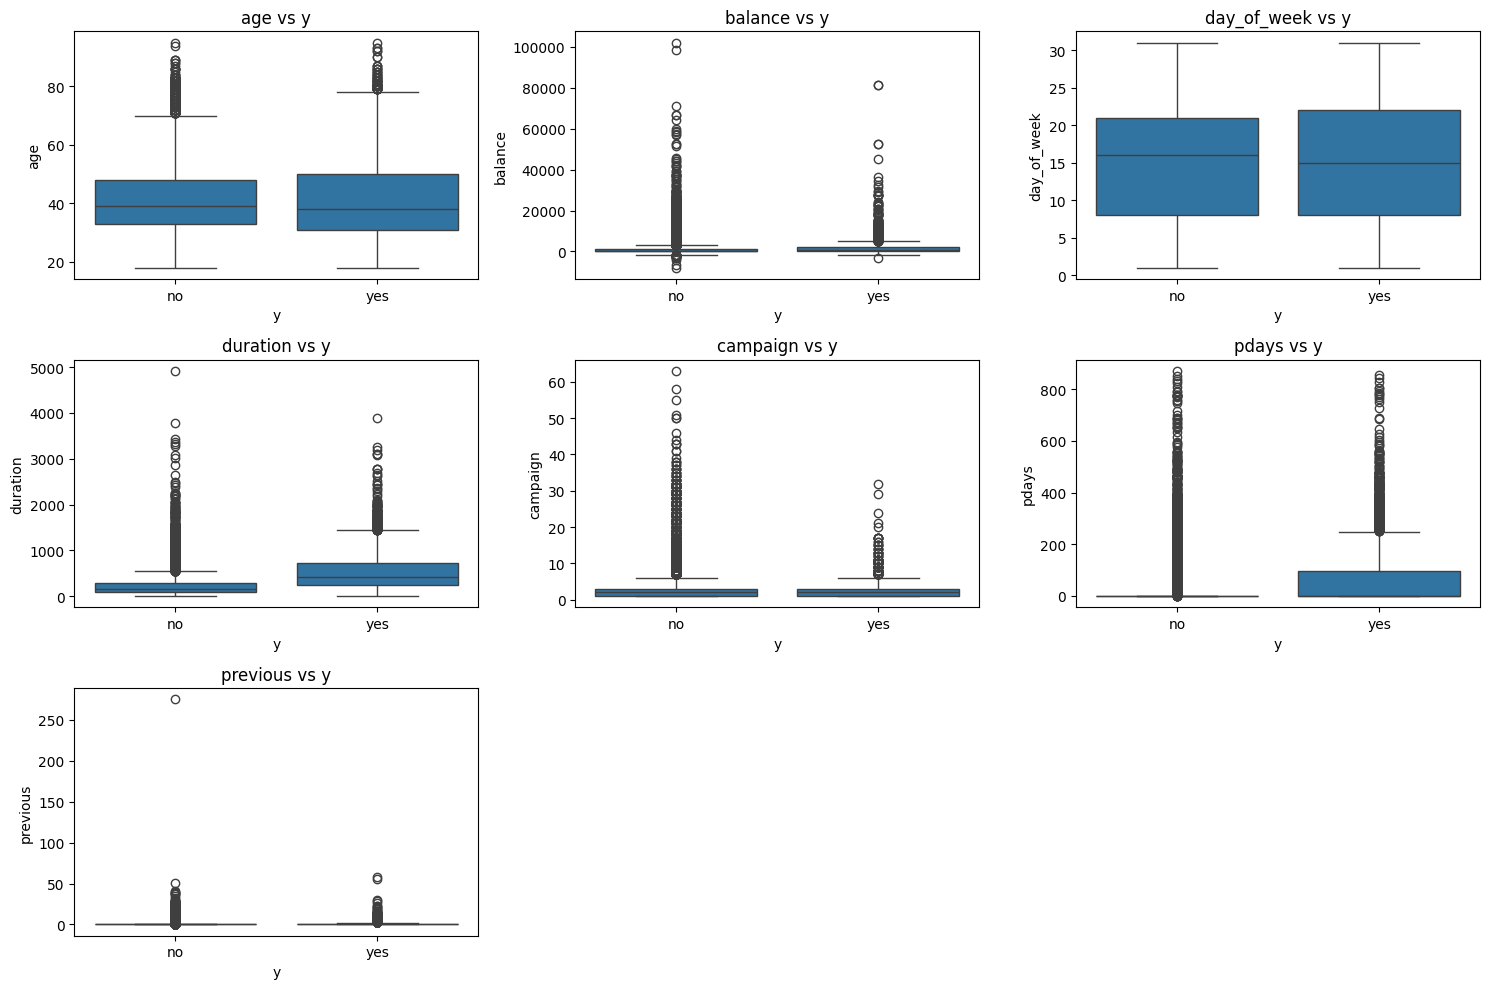

In [82]:
# --- Numerical vs Target (y) ---
plt.figure(figsize=(15, 10))
for i, col in enumerate(num_cols):
    plt.subplot(3, 3, i + 1)
    sns.boxplot(x='y', y=col, data=bankdata)
    plt.title(f'{col} vs y')
    plt.tight_layout()
plt.show()

*   Based on the duration vs target y, looks like the higher contact duration results in a positive outcome of the target variable
*   Based on the pdays vs target y, looks like the contacting the customer also results in a positive outcome of the target variable

# **Data Preprocessing:**


Data Cleaning - Handling missing data and fixing anomalies or outliers to reduce noise.

In [83]:
#check for missing values in dataset
print(bankdata[num_cols].isnull().sum())
print("\n", bankdata[cat_cols].isnull().sum())

age            0
balance        0
day_of_week    0
duration       0
campaign       0
pdays          0
previous       0
dtype: int64

 job            288
marital          0
education     1857
default          0
housing          0
loan             0
contact      13020
month            0
poutcome     36959
y                0
dtype: int64


There are no missing values in the numerical variable colums, in constrast with the categorical variable columns that has a lot of missing values. Lets check the missing percentage for each of the relavent categories.

In [84]:
#colmns that have missing values
m_cols = ['job','education','contact','poutcome']
missing_percentages = bankdata[m_cols].isnull().mean() * 100
print(missing_percentages.sort_values(ascending=False))

poutcome     81.747805
contact      28.798301
education     4.107407
job           0.637013
dtype: float64


The variable 'poutcome' has 81.8% missing values. A further look into the variable's description reveals that it is a variable for the outcome of the previous marketing campaign. It is marked as either a 'failure','other' or 'sucess'. We also examine the 'pdays' variable for number of days that passed by after the client was last contacted from a previous marketing campaign. A value of -1 means that there was no previous contact, i.e its their first time being contacted.

In [85]:
#check value counts
pout_counts = bankdata['poutcome'].value_counts(dropna=False)
pdays_counts = bankdata['pdays'].value_counts(dropna=False)
print(pout_counts)
print(pdays_counts)

poutcome
NaN        36959
failure     4901
other       1840
success     1511
Name: count, dtype: int64
pdays
-1      36954
 182      167
 92       147
 183      126
 91       126
        ...  
 749        1
 769        1
 587        1
 778        1
 854        1
Name: count, Length: 559, dtype: int64


We check the value counts and find that the majority of 'poutcome' is nonexistent (36,954 out of 36,959) because the clients had never been contacted before and thus haven't been in any previous marketing campaign. We will keep the values as is since they provide information on who has been contacted before and those that have not.

---

Now lets move on to the variable 'contact', which we saw previously is missing 28.8% of data inputs.  

In [86]:
#check value counts
con_count = bankdata['contact'].value_counts(dropna=False)
print(con_count)

contact
cellular     29285
NaN          13020
telephone     2906
Name: count, dtype: int64


We decide to keep the 'contact' data as is since the value of 'NaN' still provides some information about the subscription probabilty.


---

As for the variables 'education' and 'job' there are very small number of missing values,  4.1% and 0.6% respectively. We label missing data as 'Unknown' and consider it another possibe value.

In [87]:
#replace NaN values to strings of 'unknown'
#we only change null values to strings of 'NaN' in poutcome
bankdata['poutcome'] = bankdata['poutcome'].fillna('NaN')
bankdata['contact'] = bankdata['contact'].fillna('unknown')
bankdata['education'] = bankdata['education'].fillna('unknown')
bankdata['job'] = bankdata['job'].fillna('unknown')

We now double check our data and now have no missing values in our categorical variables. We're now ready to train our model.

In [88]:
#colmns that have missing values
m_cols = ['job','education','contact','poutcome']
missing_percentages = bankdata[m_cols].isnull().mean() * 100
print(missing_percentages.sort_values(ascending=False))

job          0.0
education    0.0
contact      0.0
poutcome     0.0
dtype: float64


# **Model Training and Testing**
## Logistic regression model
Binary classification using the numerical variables.

ROC_AUG score:  0.831
              precision    recall  f1-score   support

          no       0.90      0.98      0.94      9932
         yes       0.59      0.16      0.26      1371

    accuracy                           0.88     11303
   macro avg       0.74      0.57      0.60     11303
weighted avg       0.86      0.88      0.85     11303



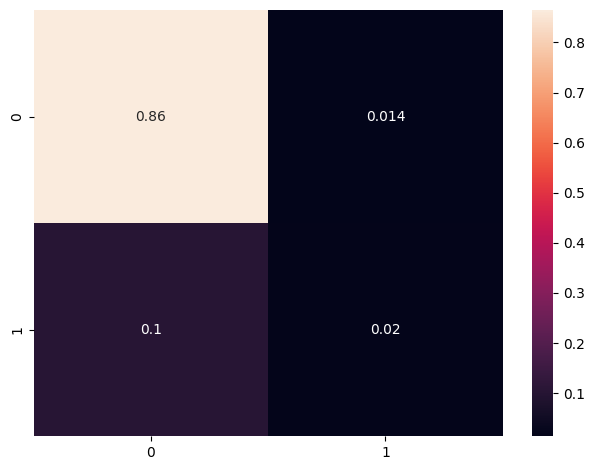

In [89]:
#split dataset into feature and target variables
X1 = bankdata[num_cols]
y1 = bankdata['y']

#split X and y into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X1, y1, test_size=0.25, random_state=16)

#normalize the training and testing data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.fit_transform(X_test)

# instantiate the logistic model
logreg = LogisticRegression(solver='liblinear',random_state=16)

# fit the model with numerical data
logreg.fit(X_train_scaled, y_train)

#predict using test set
y_pred = logreg.predict(X_test_scaled)

#get relavent metrics
roc_score = metrics.roc_auc_score(y_test, logreg.predict_proba(X_test_scaled)[:, 1])
cla_rep = metrics.classification_report(y_test, y_pred,zero_division=0)
cnf_matrix = metrics.confusion_matrix(y_test, y_pred,normalize='all')

#display metric results
print(f"ROC_AUG score: {roc_score: .3f}")
print(cla_rep)
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True )
plt.tight_layout()
plt.show()

## **Naive Bayes** for binary classification.
 Using only the categorical variables, We use an ordinal encoder to assign a unique number to each category within a feature variable.

ROC_AUG score: 0.761
              precision    recall  f1-score   support

          no       0.91      0.97      0.94      9932
         yes       0.55      0.30      0.39      1371

    accuracy                           0.89     11303
   macro avg       0.73      0.63      0.66     11303
weighted avg       0.87      0.89      0.87     11303



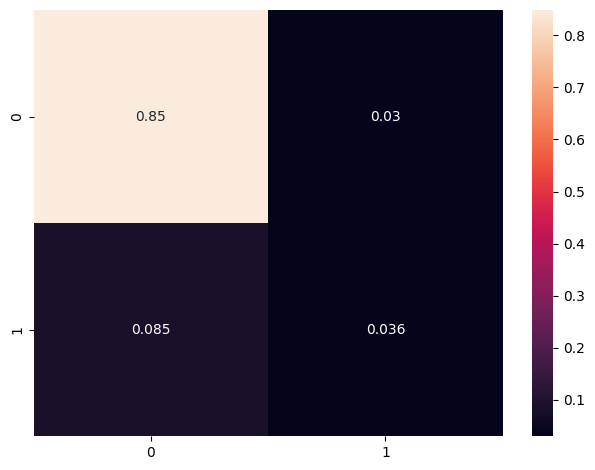

In [90]:
#split dataset into feature and target variables
X2 = bankdata[cat_cols]
X2 = X2.drop('y',axis=1) #'y' was included in cat_cols, thus have to drop it
y2 = bankdata['y']

#split X2 and y into training and testing sets
X2_train, X2_test, y_train, y_test = train_test_split(X2, y2, test_size=0.25, random_state=16)

#make pipeline for Catergorical Naive Bayes and Ordinal encoder for categorical data
pipe_cnb = make_pipeline(
              OrdinalEncoder(dtype=int),
              CategoricalNB(alpha=1.0, min_categories=2)
              # min_categories prevents issues with rare values
)

#fit model to categorical data
pipe_cnb.fit(X2_train, y_train)

#make prediction using test data
y_pred_cnb = pipe_cnb.predict(X2_test)

#get relavent metrics
roc_score_cnb = metrics.roc_auc_score(y_test, pipe_cnb.predict_proba(X2_test)[:, 1])
cla_rep_cnb = metrics.classification_report(y_test, y_pred_cnb)
cnf_matrix_cnb = metrics.confusion_matrix(y_test, y_pred_cnb,normalize='all')

#display metric results
print(f'ROC_AUG score: {roc_score_cnb :.3f}')
print(cla_rep_cnb)
sns.heatmap(pd.DataFrame(cnf_matrix_cnb), annot=True )
plt.tight_layout()
plt.show()

## **Feature-subset Ensemble** with soft voting.
We combine the two model's predictions and average their probability estimates to get a final result.

ROC_AUG score: 0.892
              precision    recall  f1-score   support

          no       0.89      0.99      0.94      9932
         yes       0.70      0.15      0.25      1371

    accuracy                           0.89     11303
   macro avg       0.79      0.57      0.60     11303
weighted avg       0.87      0.89      0.86     11303



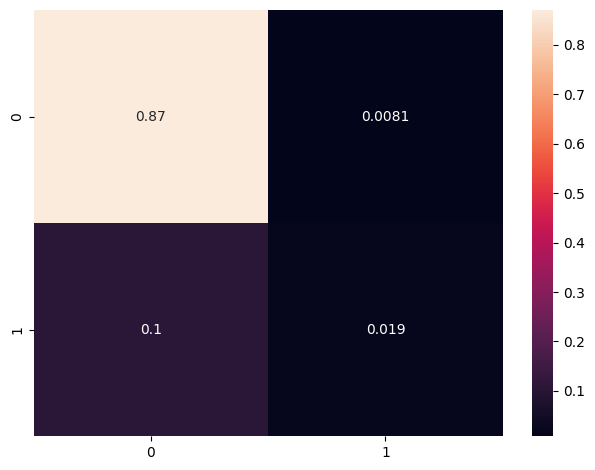

In [91]:
# Get probability predictions (classification)
proba_num = logreg.predict_proba(X_test_scaled)[:, 1]   # prob of class 1
proba_cat = pipe_cnb.predict_proba(X2_test)[:, 1]

# Simple equal-weight average of the two proabilities
final_proba = (proba_num + proba_cat) / 2.0
final_pred  = np.where(final_proba >= 0.5, 'yes', 'no')

#get relavent metrics for ensemble of the two models
roc_score_ens = metrics.roc_auc_score(y_test, final_proba)
cla_rep_ens = metrics.classification_report(y_test, final_pred )
cnf_matrix_ens = metrics.confusion_matrix(y_test, final_pred ,normalize='all')

#display metric results
print(f'ROC_AUG score: {roc_score_ens :.3f}')
print(cla_rep_ens)
sns.heatmap(pd.DataFrame(cnf_matrix_ens), annot=True )
plt.tight_layout()
plt.show()

# **Model Selection**


                 Model  Accuracy  Precision    Recall  F1 Score       AUC
0  Logistic Regression  0.902389   0.654888  0.350347  0.456486  0.904987
1        Random Forest  0.905338   0.661686  0.390674  0.491284  0.926644
2    Gradient Boosting  0.906149   0.661856  0.404537  0.502151  0.922810
3                  SVM  0.903200   0.678385  0.328292  0.442463  0.902497


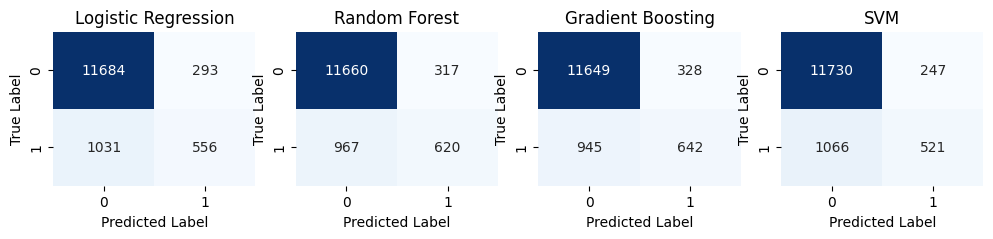

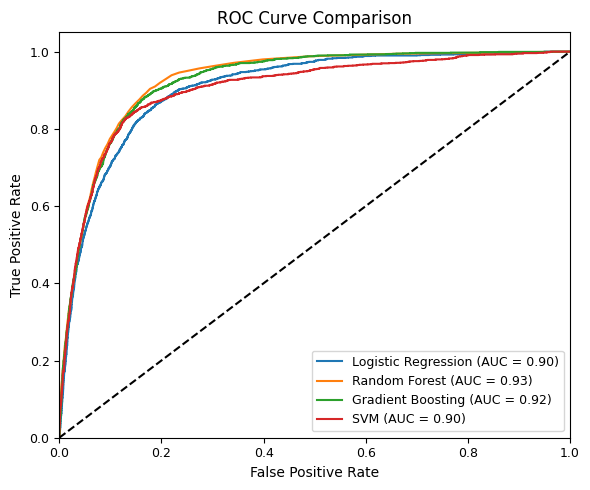

<Figure size 640x480 with 0 Axes>

In [68]:
#from ucimlrepo import fetch_ucirepo

# Ensure X and y are defined. If not, fetch the dataset.
#if 'X' not in globals() or 'y' not in globals():
#    print("Fetching bank_marketing data as X and y are not defined.")
#    bank_marketing = fetch_ucirepo(id=222)
#    X = bank_marketing.data.features
#    y = bank_marketing.data.targets

if isinstance(y, pd.DataFrame):
    y = LabelEncoder().fit_transform(y['y'])
#else:
#    y = LabelEncoder().fit_transform(y)

# Split Data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# Define Preprocessing
numeric_features = ['age', 'balance', 'day_of_week', 'duration', 'campaign', 'pdays', 'previous']
categorical_features = ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'poutcome']

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ])

# Define Models
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000, random_state=42),
    "Random Forest": RandomForestClassifier(random_state=42),
    "Gradient Boosting": GradientBoostingClassifier(random_state=42),
    "SVM": SVC(probability=True, random_state=42)
}


# Evaluate Models
# Setup a 2x2 grid for Confusion Matrices
fig_cm, axes = plt.subplots(1, 4, figsize=(12, 2))
axes = axes.flatten()

# Setup a single plot for ROC Curves
fig_roc = plt.figure(figsize=(6, 5))

results = []
for i, (name, model) in enumerate(models.items()):
    clf = Pipeline(steps=[('preprocessor', preprocessor), ('classifier', model)])
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    y_proba = clf.predict_proba(X_test)[:, 1]

    # --- Confusion Matrix ---
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, ax=axes[i])
    axes[i].set_title(f'{name}')
    axes[i].set_xlabel('Predicted Label')
    axes[i].set_ylabel('True Label')

    # --- ROC Curve ---
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    auc = roc_auc_score(y_test, y_proba)
    # Plot on the active ROC figure
    plt.figure(fig_roc.number)
    plt.plot(fpr, tpr, label=f'{name} (AUC = {auc:.2f})', linewidth=1.5)

    results.append({
        "Model": name,
        "Accuracy": accuracy_score(y_test, y_pred),
        "Precision": precision_score(y_test, y_pred),
        "Recall": recall_score(y_test, y_pred),
        "F1 Score": f1_score(y_test, y_pred),
        "AUC": roc_auc_score(y_test, y_proba)
    })

# Print Results
results_df = pd.DataFrame(results)
print(results_df)

# --- Finalize ROC Curve Comparison ---
plt.plot([0, 1], [0, 1], 'k--', lw=1.5) # Diagonal line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=10)
plt.ylabel('True Positive Rate', fontsize=10)
plt.title('ROC Curve Comparison', fontsize=12)
plt.xticks(fontsize=9)
plt.yticks(fontsize=9)
plt.legend(loc="lower right", fontsize=9)
plt.tight_layout()
plt.show()

# --- Finalize Confusion Matrices ---
plt.figure(fig_cm.number)
fig_cm.suptitle('Confusion Matrices', fontsize=12)
fig_cm.tight_layout() # Trims excess whitespace
plt.show()


* **Best Overall: Gradient Boosting** remains the strongest choice. It has the highest F1 Score (0.50) and AUC (0.92), offering the best balance. The data cleaning slightly improved its stability.List item



# Cumulative Gains Chart

In [69]:
!pip install ucimlrepo > /dev/null
from ucimlrepo import fetch_ucirepo

bank_marketing = fetch_ucirepo(id=222)
# data (as pandas dataframes)
X = bank_marketing.data.features
y = bank_marketing.data.targets
print("Metadata (first few entries):", {k: bank_marketing.metadata[k] for k in list(bank_marketing.metadata)[:3]})
# variable information
display(bank_marketing.variables.head(3))

Metadata (first few entries): {'uci_id': 222, 'name': 'Bank Marketing', 'repository_url': 'https://archive.ics.uci.edu/dataset/222/bank+marketing'}


,name,role,type,demographic,description,units,missing_values
0,age,Feature,Integer,Age,None,None,no
1,job,Feature,Categorical,Occupation,"type of job (categorical: 'admin.','blue-colla...",None,no
2,marital,Feature,Categorical,Marital Status,"marital status (categorical: 'divorced','marri...",None,no


In [70]:
import pandas as pd
bankdata = pd.concat([X, y], axis=1)
display(bankdata.head(3))

,age,job,marital,education,default,balance,housing,loan,contact,day_of_week,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,NaN,5,may,261,1,-1,0,NaN,no
1,44,technician,single,secondary,no,29,yes,no,NaN,5,may,151,1,-1,0,NaN,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,NaN,5,may,76,1,-1,0,NaN,no


In [71]:
# Drop 'poutcome' as it has too many missing values and its meaning is captured by pdays = -1
if 'poutcome' in bankdata.columns:
    bankdata = bankdata.drop('poutcome', axis=1)
# Fill missing 'contact' values with 'unknown'
if 'contact' in bankdata.columns:
    bankdata['contact'] = bankdata['contact'].fillna('unknown')
# Fill missing 'education' values with the mode
if 'education' in bankdata.columns:
    bankdata['education'] = bankdata['education'].fillna(bankdata['education'].mode()[0])
# Fill missing 'job' values with the mode
if 'job' in bankdata.columns:
    bankdata['job'] = bankdata['job'].fillna(bankdata['job'].mode()[0])
# Convert 'y' target variable to ninary (0 for 'no', 1 for 'yes')
bankdata['y'] = bankdata['y'].map({'no': 0, 'yes': 1})
print("Missing values after handling:")
print(bankdata[['job', 'education', 'contact']].isnull().sum())
print("\nValue counts for target variable 'y' after conversion:")
print(bankdata['y'].value_counts())

Missing values after handling:
job          0
education    0
contact      0
dtype: int64

Value counts for target variable 'y' after conversion:
y
0    39922
1     5289
Name: count, dtype: int64


In [72]:
# Identify categorical columns for one-hot encoding
cat_cols_to_encode = bankdata.select_dtypes(include='object').columns
# Apply one-hot encoding
bankdata_encoded = pd.get_dummies(bankdata, columns=cat_cols_to_encode, drop_first=True)
display(bankdata_encoded.head(3))

,age,balance,day_of_week,duration,campaign,pdays,previous,y,job_blue-collar,job_entrepreneur,...,month_dec,month_feb,month_jan,month_jul,month_jun,month_mar,month_may,month_nov,month_oct,month_sep
0,58,2143,5,261,1,-1,0,0,False,False,...,False,False,False,False,False,False,True,False,False,False
1,44,29,5,151,1,-1,0,0,False,False,...,False,False,False,False,False,False,True,False,False,False
2,33,2,5,76,1,-1,0,0,False,True,...,False,False,False,False,False,False,True,False,False,False


In [73]:
from sklearn.model_selection import train_test_split

# Separate features (X_df) and target (y_df) from the dataframe
X_df = bankdata_encoded.drop('y', axis=1)
y_df = bankdata_encoded['y']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_df, y_df, test_size=0.3, random_state=42, stratify=y_df)

print(f"Shape of X_train: {X_train.shape}")
print(f"Shape of X_test: {X_test.shape}")
print(f"Shape of y_train: {y_train.shape}")
print(f"Shape of y_test: {y_test.shape}")

Shape of X_train: (31647, 37)
Shape of X_test: (13564, 37)
Shape of y_train: (31647,)
Shape of y_test: (13564,)


In [74]:
from sklearn.ensemble import RandomForestClassifier

# Define and train a RandomForestClassifier
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train, y_train)


RandomForestClassifier(random_state=42)

Business Value: Cumulative Gains Chart


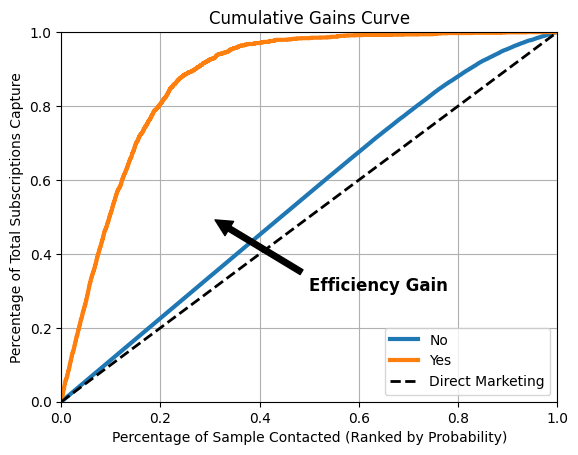

In [75]:
!pip install scikit-plot > /dev/null

import matplotlib.pyplot as plt
import numpy as np
import scipy
scipy.interp = np.interp

import scikitplot as skplt
from sklearn.metrics import roc_curve, auc

# predict probabilities
y_prob = rf_model.predict_proba(X_test)
# plot cumulative gains
ax = skplt.metrics.plot_cumulative_gain(y_test, y_prob)

# Customize legend labels
handles, current_labels = ax.get_legend_handles_labels()
label_map = {
    'Class 1': 'Yes',
    'Class 0': 'No',
    'Baseline': 'Direct Marketing'
}
new_labels = [label_map.get(label, label) for label in current_labels]
ax.legend(handles, new_labels, loc='lower right') # Update legend

plt.xlabel('Percentage of Sample Contacted (Ranked by Probability)')
plt.ylabel('Percentage of Total Subscriptions Capture')
print(f'Business Value: Cumulative Gains Chart')

 # Add an arrow and a text box pointing to the gap
plt.annotate('Efficiency Gain',
             xy=(0.3, 0.5), xytext=(0.5, 0.3),
             arrowprops=dict(facecolor='black', shrink=0.05),
             fontsize=12, fontweight='bold')
plt.show()

This cumulative graph offers a visual aid to the predictive power of our model. The 80/20 ratio gain presented in the efficiency gain gap where 80% of the 'yes' responses can be seen within 20% of the contacted sample. The overall effect is decreasing random unsucessful contacts by 80%.

# References
Moro, S., Rita, P., & Cortez, P. (2014). Bank Marketing [Dataset]. UCI Machine Learning Repository. https://doi.org/10.24432/C5K306.



